# Machine Learning Projet : Stock Return Prediction

Axel PORTIER, Lucas STALTER, Gaspard SALLURON--BESNARD

# Project Overview

This project aims to predict the direction of residual stock returns in the U.S. market using historical financial data from Qube RT. The goal is to detect weak predictive signals rather than forecast exact prices, focusing on the underlying patterns that drive short-term stock movements once market effects are removed.

The dataset includes 46 numerical features, covering anonymized identifiers (STOCK, INDUSTRY, SECTOR) and 20-day histories of residual returns (RET_1–RET_20) and trading volumes (VOLUME_1–VOLUME_20). The target variable, RET, is binary, indicating whether the residual return at time t is positive or negative.

Following a structured machine learning pipeline, we perform data quality checks, feature preprocessing, and correlation analysis, then train both baseline models (e.g., Logistic Regression, Decision Trees) and advanced algorithms (e.g., Random Forest, XGBoost, Neural Networks). Model performance is assessed using F1-score and ROC-AUC, ensuring robust evaluation despite potential class imbalance.

Ultimately, this work explores how machine learning methods can capture meaningful financial patterns to support better decision-making in quantitative trading and risk management.

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Phase I QUALITY CHECK & DATA EXPLORATION

The dataset consists of 46 descriptive features, all represented as numerical values (float or integer).

- `DATE` : an anonymized and randomized date index, without temporal continuity or sequential dependency.

- `STOCK` : an identifier representing the stock.

- `INDUSTRY`, `INDUSTRY_GROUP`, `SUB_INDUSTRY`, `SECTOR`: hierarchical categorical indices describing the economic domain of each stock (e.g., aeronautics, IT, oil, etc.).

- `RET_1` to `RET_20`: historical residual returns over the last 20 days, where `RET_1` corresponds to the previous day’s residual return, `RET_2` to two days before, and so on.

- `VOLUME_1` to `VOLUME_20`: historical relative trading volumes over the last 20 days, where `VOLUME_1` is the volume of the previous day.

The target variable, `RET`, is binary and represents the sign of the residual stock return at time t (i.e., positive or negative).

In the initial phase, the analysis focuses on understanding the dataset’s structure — specifically investigating missing values, class balance, and potential correlations among features.

### In the dataset we must acknowledge this : SUB INDUSTRY ⊂ INDUSTRY ⊂ INDUSTRY_GROUP ⊂ SECTOR 

## I) Data Loading & Initial Verification

In [3]:
x_train = pd.read_csv('./x_train.csv', index_col='ID')
y_train = pd.read_csv('./y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1) #axis = 1 concat by columns
test = pd.read_csv('./x_test.csv', index_col='ID')
print(train.columns)
train.head()

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET'],
      dtype='object')


,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


### Dataset features's types

In [4]:
train.info()
train.dtypes.value_counts()


<class 'pandas.core.frame.DataFrame'>
Index: 418595 entries, 0 to 418594
Data columns (total 47 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            418595 non-null  int64  
 1   STOCK           418595 non-null  int64  
 2   INDUSTRY        418595 non-null  int64  
 3   INDUSTRY_GROUP  418595 non-null  int64  
 4   SECTOR          418595 non-null  int64  
 5   SUB_INDUSTRY    418595 non-null  int64  
 6   RET_1           416236 non-null  float64
 7   VOLUME_1        353570 non-null  float64
 8   RET_2           416130 non-null  float64
 9   VOLUME_2        352209 non-null  float64
 10  RET_3           416088 non-null  float64
 11  VOLUME_3        350776 non-null  float64
 12  RET_4           416051 non-null  float64
 13  VOLUME_4        347598 non-null  float64
 14  RET_5           416011 non-null  float64
 15  VOLUME_5        343902 non-null  float64
 16  RET_6           415998 non-null  float64
 17  VOLUME_6       

float64    40
int64       6
bool        1
Name: count, dtype: int64

### Type of the target

In [5]:
print(train['RET'].value_counts(normalize=True))
print(train['RET'].dtype)


RET
False    0.501079
True     0.498921
Name: proportion, dtype: float64
bool


The target variable `RET` is well balanced, with approximately 50.1% False and 49.9% True values, indicating no significant class imbalance in the dataset. However, to experiment with different approaches, we will still address the imbalance problem later in the project.

### Dataset's dimensions :

In [6]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()
train.describe(include='all')

Train shape: (418595, 47)
Test shape: (198429, 46)


,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
count,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,416236.000000,353570.000000,416130.000000,352209.000000,...,351333.000000,413294.000000,356281.000000,413288.000000,351009.000000,413282.000000,351266.000000,413254.000000,350738.000000,418595
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209749
mean,108.659002,3373.567833,37.176020,12.697959,5.483845,90.391663,0.001383,-0.071502,0.000973,-0.075230,...,-0.076018,0.001642,-0.087854,0.001131,-0.076147,-0.000798,-0.076496,-0.000027,-0.076337,NaN
std,61.891642,1533.157749,19.706505,7.231701,2.410113,47.491157,0.031311,3.038658,0.030987,2.635549,...,2.185741,0.031914,2.094459,0.031435,2.423121,0.030738,2.229668,0.033347,2.721355,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.845324,-2.434414,-0.770751,-3.007262,...,-5.600056,-0.825014,-4.610393,-0.876157,-4.167784,-0.880000,-2.341887,-0.785714,-2.768928,NaN
25%,56.000000,2478.000000,22.000000,6.000000,4.000000,49.000000,-0.010970,-0.555394,-0.011312,-0.540629,...,-0.533574,-0.011331,-0.552613,-0.010949,-0.539491,-0.012139,-0.527846,-0.011682,-0.542790,NaN
50%,104.000000,3560.000000,43.000000,15.000000,6.000000,104.000000,0.000637,-0.282609,0.000401,-0.278437,...,-0.272271,0.000433,-0.285480,0.000000,-0.281753,0.000000,-0.277674,0.000000,-0.283405,NaN
75%,161.000000,4606.000000,53.000000,19.000000,7.000000,128.000000,0.012950,0.047759,0.012326,0.041177,...,0.029131,0.012862,0.027272,0.012180,0.027639,0.011236,0.030201,0.011712,0.035795,NaN


# II) Data Processing

### From now on, we are gonna work on the train by the intermediary of the ***cleaning_train*** dataset in order to clearly seperate both

For simplicity and computational efficiency in testing and throughout the rest of the project, we will focus on **the last 10 days** of returns and volumes.

In [7]:
to_drop = [f'RET_{day}' for day in range(11,21)]
to_drop += [f'VOLUME_{day}' for day in range(11,21)]
cleaning_train = train.drop(columns= to_drop).copy()

## II.1) Missing values analysis

In [8]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100 # percentage of nan values per feature (axis=0 : each nbr of nan for each features)

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.563552
VOLUME_1          15.534108
RET_2              0.588875
VOLUME_2          15.859243
RET_3              0.598908
VOLUME_3          16.201579
RET_4              0.607747
VOLUME_4          16.960785
RET_5              0.617303
VOLUME_5          17.843739
RET_6              0.620409
VOLUME_6          17.848756
RET_7              0.617542
VOLUME_7          17.643068
RET_8              0.626620
VOLUME_8          17.653818
RET_9              0.640715
VOLUME_9          17.510481
RET_10             0.643104
VOLUME_10         17.512154
RET                0.000000
dtype: float64

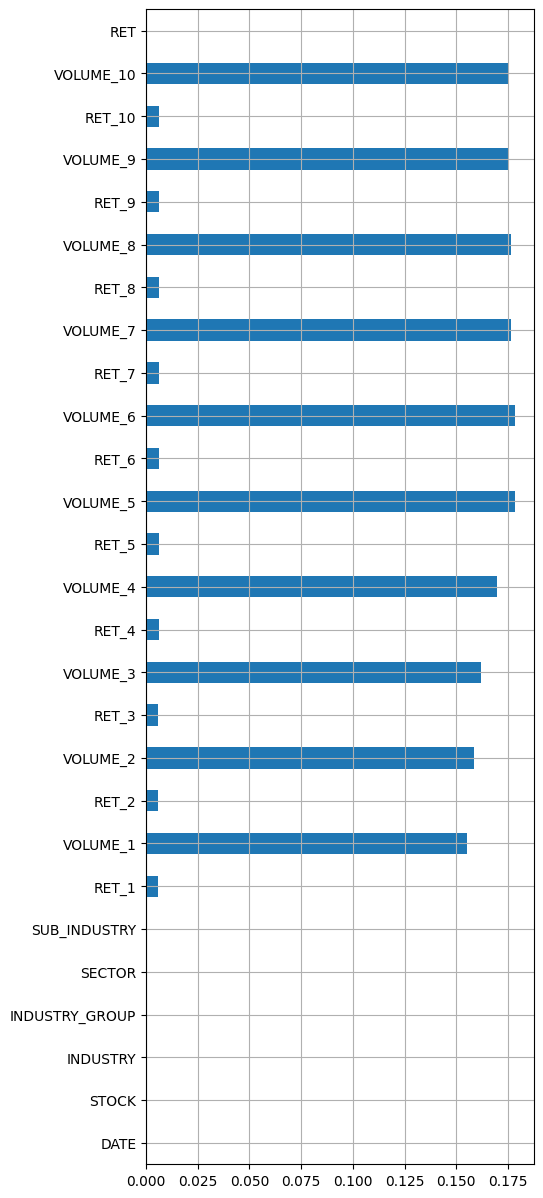

In [9]:
nb_missing = cleaning_train.isna().sum()
rate_missing = nb_missing / cleaning_train.index.nunique()
fig, ax = plt.subplots(figsize=(5,15))
ax1 = ax
rate_missing.plot(kind="barh", ax=ax1)
ax1.grid()

Most of the missing values are concentrated in the `VOLUME_1`..., with around **15% missing data**, which represents a considerable proportion. 
Consequently, a specific step will be devoted later to addressing these missing values.
It is also import to hightlight that there is no missing values in the `SECTOR` etc.

### Percentage of missing values for each unique value within  `INDUSTRY`, `INDUSTRY_GROUP`, `SECTOR`, `SUB_INDUSTRY`, `STOCK`, and `DATE`.

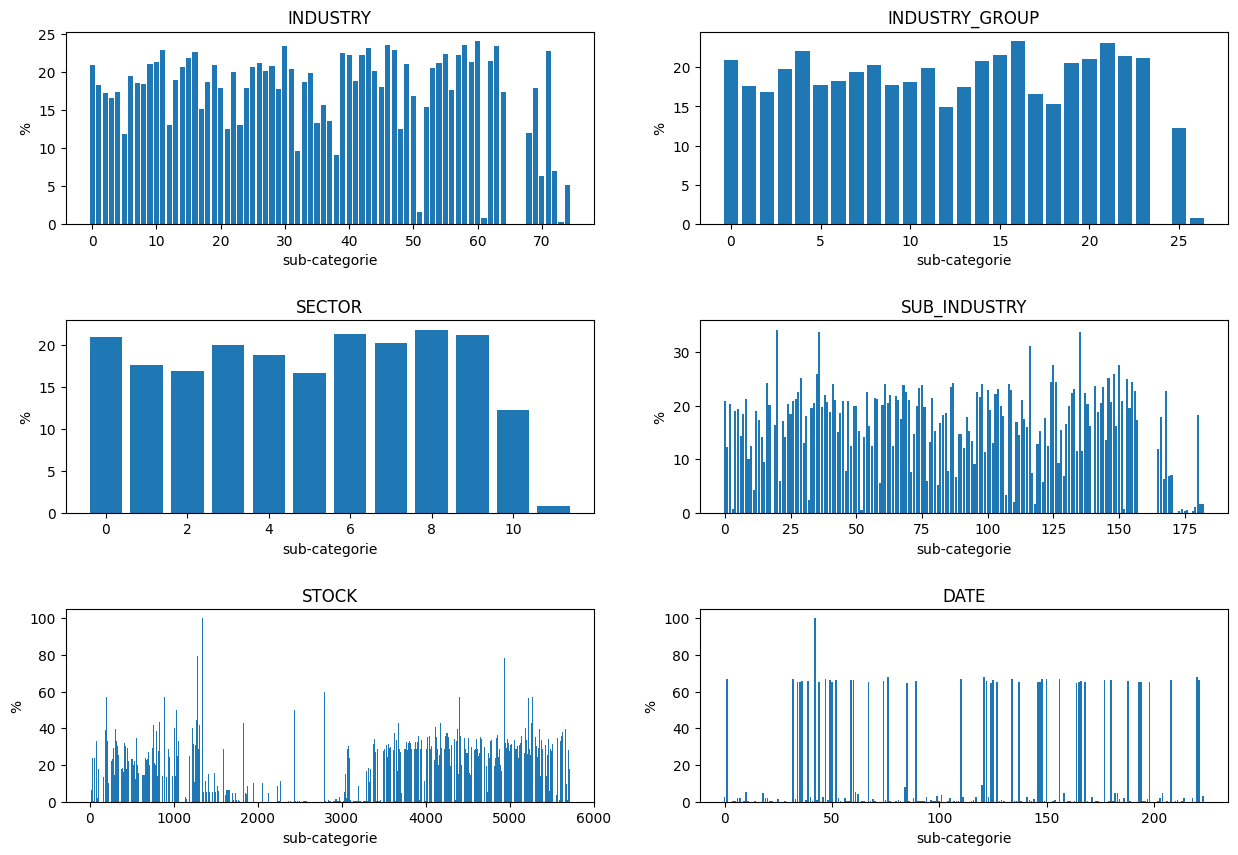

In [10]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for i,categorie in enumerate(['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'STOCK', 'DATE']): 
    plt.subplot(3,2,i+1)
    plt.title(categorie)
    X_absciss = cleaning_train[categorie].sort_values().unique()

    unique_Y_values = cleaning_train[categorie].sort_values().unique()
    Y_absciss = [(cleaning_train[cleaning_train[categorie]==sub_categorie].isna().sum(axis=1)>0).sum()/len(cleaning_train[cleaning_train[categorie]==sub_categorie])*100 for sub_categorie in unique_Y_values]
    
    plt.bar(X_absciss,Y_absciss)
    plt.xlabel('sub-categorie')
    plt.ylabel('%')
plt.show()

The plots display the percentage of NaN values per subcategory. We observe a relatively even distribution of missing values for the categorical variable SECTOR, whereas the amount of missing data in other categorical features appears less uniform.

It may be useful to investigate whether some rows mainly consist of missing values in the descriptive variables (RET and VOLUME). If that is the case, those observations can reasonably be removed, as they do not contribute meaningful information to the model.

We will first **remove rows with heavy missingness**, then **impute minor gaps** with consistent values.

### Let's remove the rows where half or more of their features `RET_` and `VOL_` are NaN

In [11]:
ret_features = [f'RET_{day}' for day in range(1,11)]
vol_features = [f'VOLUME_{day}' for day in range(1,11)]
features = vol_features + ret_features

to_drop = cleaning_train[cleaning_train[features].isna().sum(axis=1) >= len(features)*0.5][features].index
nb_drop = len(to_drop)
nb_rows = len(cleaning_train)
print(
    f"Number of rows before removing: {nb_rows}\n"
    f"Number of rows removed: {nb_drop}\n"
    f"Overall ratio (% of rows removed): {nb_drop / nb_rows * 100:.4f}%"
)


cleaning_train.drop(index = to_drop, axis=0, inplace = True)

Number of rows before removing: 418595
Number of rows removed: 54607
Overall ratio (% of rows removed): 13.0453%


About 13% of the rows were less than half complete, which is a significant proportion and an important aspect to take into account during data cleaning.

In [12]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100

DATE              0.000000
STOCK             0.000000
INDUSTRY          0.000000
INDUSTRY_GROUP    0.000000
SECTOR            0.000000
SUB_INDUSTRY      0.000000
RET_1             0.001923
VOLUME_1          2.862182
RET_2             0.002747
VOLUME_2          3.236096
RET_3             0.001923
VOLUME_3          3.629790
RET_4             0.001374
VOLUME_4          4.502896
RET_5             0.000824
VOLUME_5          5.518589
RET_6             0.000549
VOLUME_6          5.524633
RET_7             0.000000
VOLUME_7          5.287812
RET_8             0.000000
VOLUME_8          5.300449
RET_9             0.000000
VOLUME_9          5.136983
RET_10            0.000275
VOLUME_10         5.139730
RET               0.000000
dtype: float64

From now on the stat of missing values are lower, but let's keep digging that way by replacing the missing values

### Before that let's have a look at the features distributions

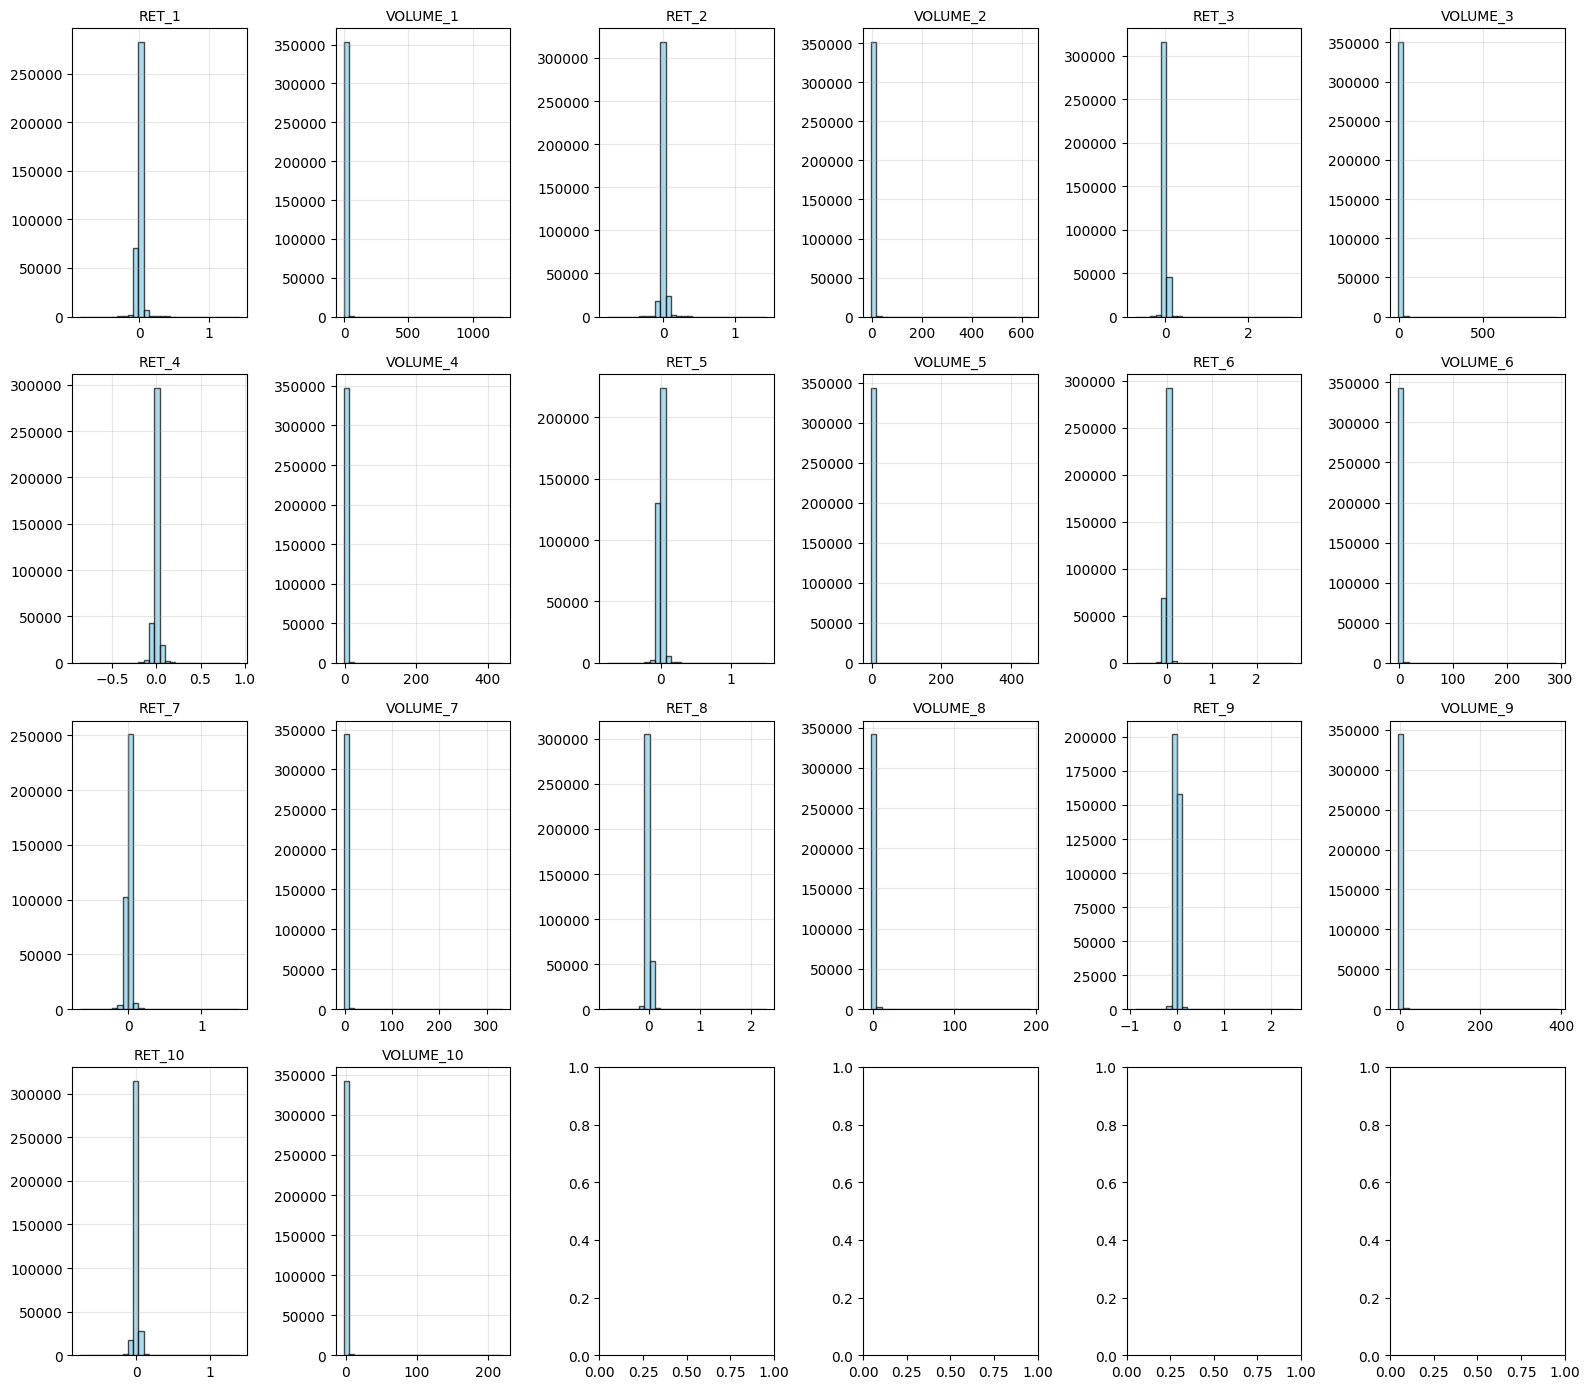

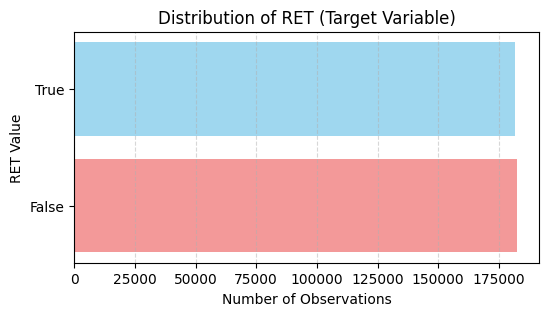

In [13]:
features = [col for col in cleaning_train.columns if col not in ["INDUSTRY", "INDUSTRY_GROUP", "SECTOR", "SUB_INDUSTRY", "STOCK", "DATE","RET"]]
n_cols = 6
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 14))
axes = axes.flatten()

for i, feature in enumerate(features):
    cleaning_train[feature].hist(bins=30, ax=axes[i], alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(feature, fontsize=10)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

ret_counts = cleaning_train["RET"].value_counts()
plt.figure(figsize=(6, 3))
plt.barh(ret_counts.index.astype(str), ret_counts.values, color=["lightcoral", "skyblue"], alpha=0.8)
plt.title("Distribution of RET (Target Variable)")
plt.xlabel("Number of Observations")
plt.ylabel("RET Value")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


The plots are not very meaningful since most values are centered around 0. This is consistent with the nature of the data: we are dealing with relative volumes and residual returns, which are either normalized or expressed relative to market behavior after removing overall market effects. Nevertheless, it is interesting to note that the RET values are fairly well balanced.

In [14]:
volume = pd.DataFrame(columns=['day', 'ret_mean', 'ret_median', 'ret_std', 'vol_mean', 'vol_median', 'vol_std'])
for day in range(1,11):
    volume.loc[day] =[day, cleaning_train[f'RET_{day}'].mean(), cleaning_train[f'RET_{day}'].median(), cleaning_train[f'RET_{day}'].std(), 
                      cleaning_train[f'VOLUME_{day}'].mean(), cleaning_train[f'VOLUME_{day}'].median(), cleaning_train[f'VOLUME_{day}'].std()]
volume

,day,ret_mean,ret_median,ret_std,vol_mean,vol_median,vol_std
1,1.0,0.001656,0.000814,0.030582,-0.071502,-0.282609,3.038658
2,2.0,0.001353,0.000876,0.030159,-0.075230,-0.278437,2.635549
3,3.0,0.002575,0.001251,0.030920,-0.097235,-0.278277,2.490831
4,4.0,-0.001089,-0.000636,0.029817,-0.088976,-0.275435,1.730786
5,5.0,0.000765,0.000000,0.031250,-0.092162,-0.281238,1.848980
6,6.0,-0.000166,0.000000,0.030534,-0.100509,-0.288125,1.689070
7,7.0,0.000240,0.000000,0.030233,-0.084719,-0.284789,1.839735
8,8.0,-0.000407,-0.000446,0.030708,-0.087038,-0.289772,1.595810
9,9.0,-0.000891,-0.000233,0.032157,-0.090856,-0.298185,1.857252
10,10.0,0.000397,0.000000,0.030469,-0.092194,-0.295754,1.653336


### Missing Value Imputation Choice for `VOL_`

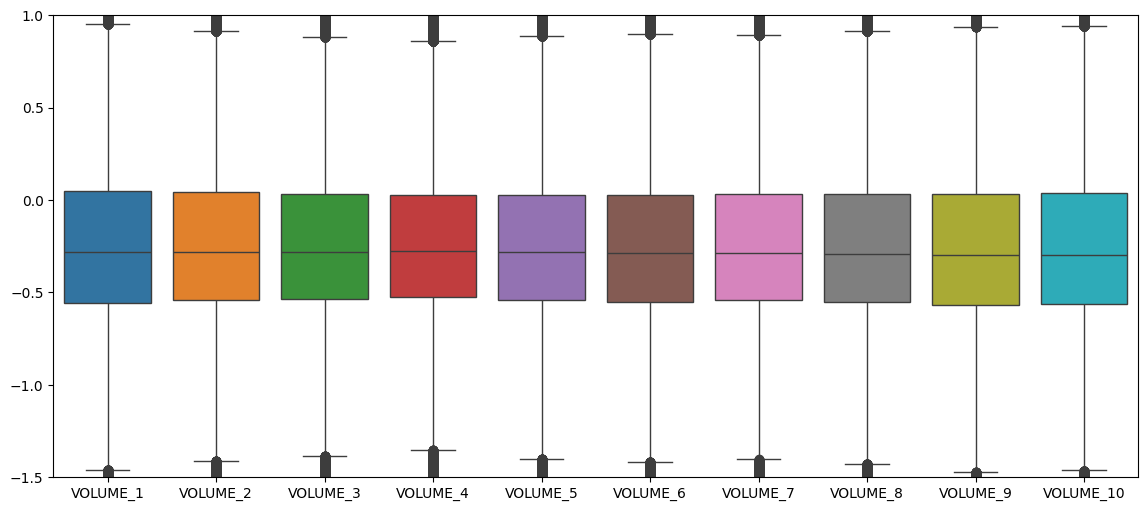

In [15]:
plt.figure(figsize=(14, 6))  # largeur = 20, hauteur = 6
sns.boxplot(cleaning_train[[f'VOLUME_{day}' for day in range(1,11)]])
plt.ylim((-1.5,1))
plt.show()

### Justification for Missing-Value Imputation (Volumes)

**A quick reminder — what is skewness?**  
Skewness describes the *asymmetry* of a distribution:  
- **Symmetric**: left and right tails are similar; mean ≈ median.  
- **Left-skewed (negative skew)**: longer/larger tail on the left; **mean < median**.  
- **Right-skewed (positive skew)**: longer/larger tail on the right; **mean > median**.  

**What we observe for `VOLUME_1`–`VOLUME_10`:**  
- The **median is around −0.25** across all volume features (i.e., slightly shifted left, not centered at 0, and showing **no extreme skew**).  
- Outliers exist but are not dominant, and we will handle them later.  

**Why we impute with the median:**  
- The **median is robust** to outliers, unlike the mean, which is affected by them.  
- Therefore, based on our boxplots, imputing with the **mean** would be too optimistic and could distort the true distribution.



In [16]:
per_feature_median_volume = cleaning_train[vol_features].median()
print(per_feature_median_volume)
cleaning_train[vol_features] = cleaning_train[vol_features].fillna(per_feature_median_volume)


VOLUME_1    -0.282609
VOLUME_2    -0.278437
VOLUME_3    -0.278277
VOLUME_4    -0.275435
VOLUME_5    -0.281238
VOLUME_6    -0.288125
VOLUME_7    -0.284789
VOLUME_8    -0.289772
VOLUME_9    -0.298185
VOLUME_10   -0.295754
dtype: float64


### Missing Value Imputation Choice for `RET_`

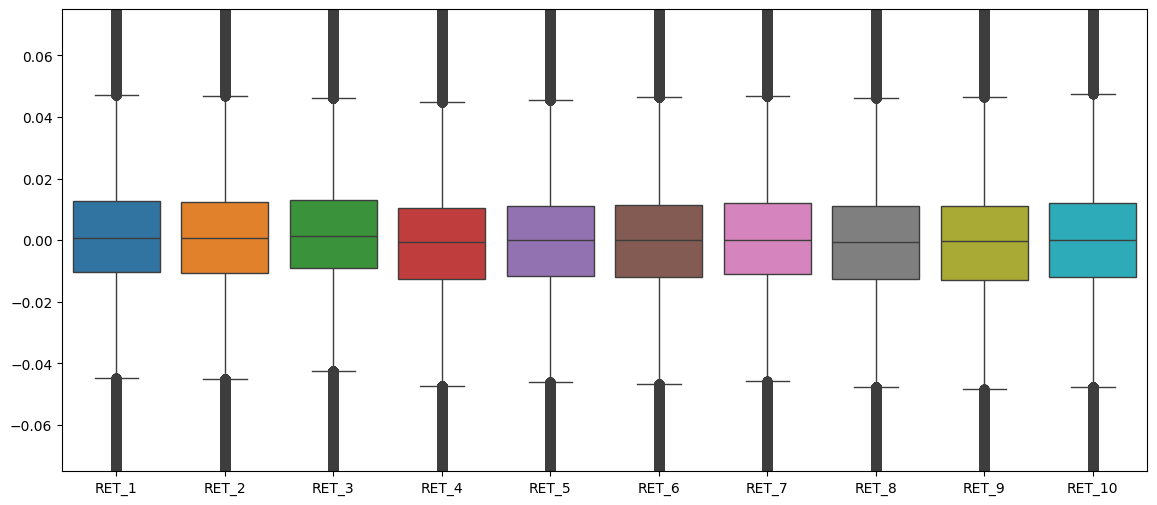

In [17]:
plt.figure(figsize=(14, 6))  # largeur = 20, hauteur = 6
sns.boxplot(cleaning_train[[f'RET_{day}' for day in range(1,11)]])
plt.ylim((-0.075,0.075))
plt.show()

For the `RET_` features, the **median is close to 0**, indicating a symmetric distribution around the center.  
Although imputing missing values with the **mean** could be appropriate in this case, we will use the **median** instead to remain consistent with a **robust imputation strategy** less sensitive to potential outliers.


In [18]:
per_feature_median_return  = cleaning_train[ret_features].median()
print(per_feature_median_return)
cleaning_train[ret_features] = cleaning_train[ret_features].fillna(per_feature_median_return)

RET_1     0.000814
RET_2     0.000876
RET_3     0.001251
RET_4    -0.000636
RET_5     0.000000
RET_6     0.000000
RET_7     0.000000
RET_8    -0.000446
RET_9    -0.000233
RET_10    0.000000
dtype: float64


### Just checking that all the features are well imputated

In [19]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100

DATE              0.0
STOCK             0.0
INDUSTRY          0.0
INDUSTRY_GROUP    0.0
SECTOR            0.0
SUB_INDUSTRY      0.0
RET_1             0.0
VOLUME_1          0.0
RET_2             0.0
VOLUME_2          0.0
RET_3             0.0
VOLUME_3          0.0
RET_4             0.0
VOLUME_4          0.0
RET_5             0.0
VOLUME_5          0.0
RET_6             0.0
VOLUME_6          0.0
RET_7             0.0
VOLUME_7          0.0
RET_8             0.0
VOLUME_8          0.0
RET_9             0.0
VOLUME_9          0.0
RET_10            0.0
VOLUME_10         0.0
RET               0.0
dtype: float64

Alright, the missing values have been successfully replaced using the median strategy.  
We can now move on to the **outlierss**, where we will different methods in order to remove them.


## II.2 Outliers handling

### IQR Method

Nb lignes supprimées IQR : 134723, equivalently to 37.0%


(-0.05, 0.05)

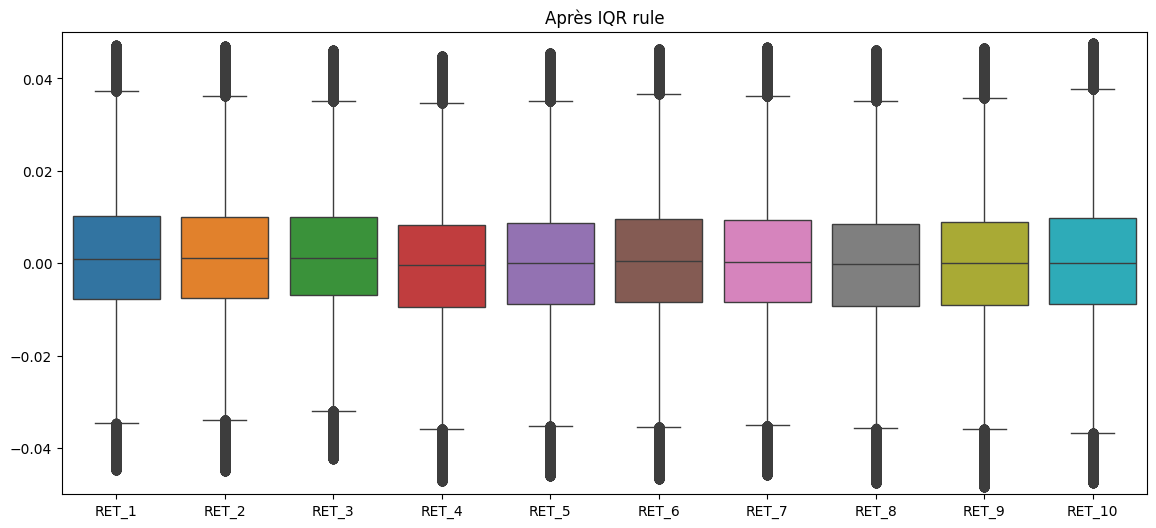

In [ ]:
features = ret_features + vol_features
X = cleaning_train[ret_features]

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
mask_iqr = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
cleaning_train_iqr = cleaning_train[mask_iqr]

nb_tot = len(cleaning_train)
nb_removed = nb_tot - len(cleaning_train_iqr)
print(f"Nb lignes supprimées IQR : {nb_removed}, equivalently to {(nb_removed/nb_tot)*100:.1f}% of total dataset")
plt.figure(figsize=(14, 6))
sns.boxplot(cleaning_train_iqr[ret_features])
plt.title("Après IQR rule")
plt.ylim((-0.05, 0.05))

The **Interquartile Range (IQR) rule** was applied to detect and remove outliers in the `RET_` features.  

$$
\text{Lower bound} = Q1 - 1.5 \times IQR
$$
$$
\text{Upper bound} = Q3 + 1.5 \times IQR
$$

$$ IQR = Q3 - Q1 $$

This method identifies values lying beyond **1.5 × IQR** from the first (Q1) and third (Q3) quartiles.  
After applying this rule, the overall distribution of returns remains consistent, with medians close to 0 and fewer extreme values.  
This confirms that the 37% removed observations were genuine outliers, allowing for a **cleaner and more stable dataset** while preserving the main statistical structure.

### IsolationForest Method

Nb lignes supprimées IQR : 18200, equivalently to 5.0% of total dataset


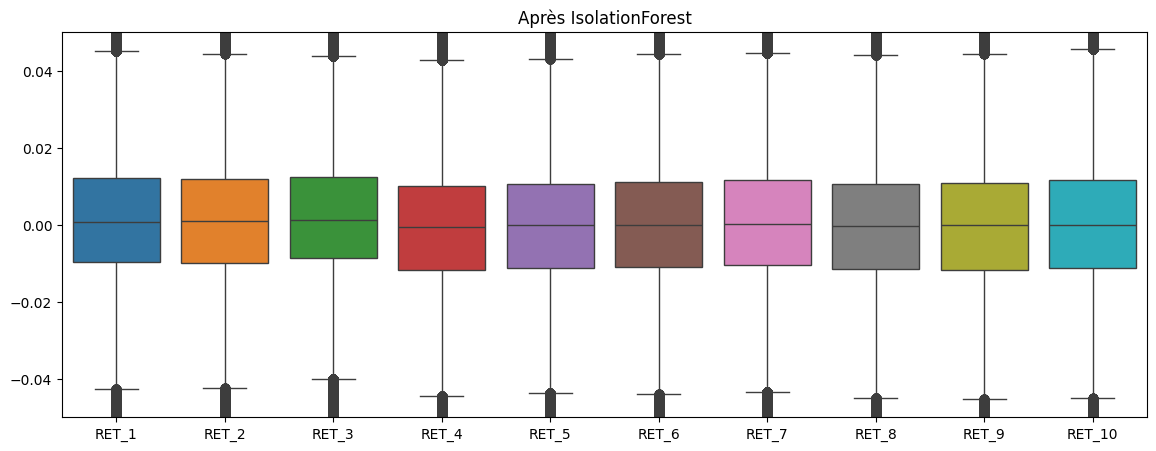

In [36]:
# --- Méthode 2 : IsolationForest ---
iso = IsolationForest(contamination=0.05, random_state=42)
y_pred_iso = iso.fit_predict(X)
cleaning_train_iso = cleaning_train[y_pred_iso == 1]  # 1 = normal, -1 = outlier

nb_tot = len(cleaning_train)
nb_removed = nb_tot - len(cleaning_train_iso)
print(f"Nb lignes supprimées IQR : {nb_removed}, equivalently to {(nb_removed/nb_tot)*100:.1f}% of total dataset")

plt.figure(figsize=(14, 5))
sns.boxplot(cleaning_train_iso[ret_features])
plt.title("Après IsolationForest")
plt.ylim((-0.05, 0.05))

plt.show()

The **Isolation Forest** algorithm is a model-based method for outlier detection.  
Unlike the IQR rule, which relies on fixed statistical thresholds, Isolation Forest identifies anomalies by **isolating observations** that differ significantly from the majority.  
It works by randomly selecting features and split values to construct multiple decision trees, and the **number of splits required to isolate a point** determines how “anomalous” it is:  
- **Normal points** require many splits (they are deeply nested).  
- **Outliers** are isolated quickly (few splits needed).  

In this analysis, we applied Isolation Forest with a contamination rate of **5%**, meaning the model assumes roughly 5% of the data could be anomalous.  

After applying the method, the **overall structure of the `RET_` features remains stable**, with medians still around 0 and distributions symmetric.  
This indicates that the algorithm primarily removed **a small proportion of extreme or inconsistent observations**, improving dataset quality without distorting its core statistical behavior.  
Overall, the data is now cleaner and more consistent for subsequent modeling steps.


## II.3 Correlation handling

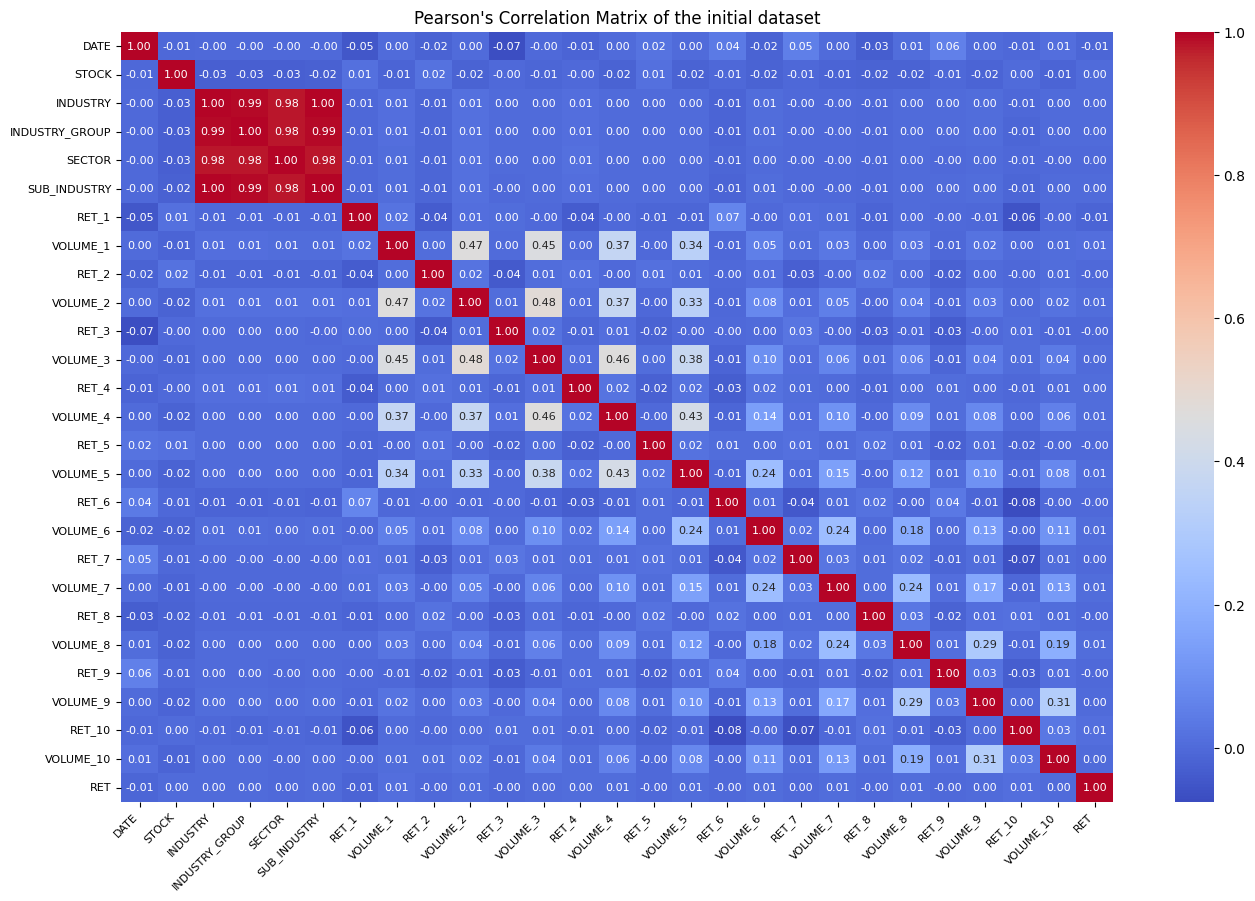

In [39]:
plt.figure(figsize=(16, 10))
pearson_corr = cleaning_train_iqr.corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Pearson's Correlation Matrix of the initial dataset")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

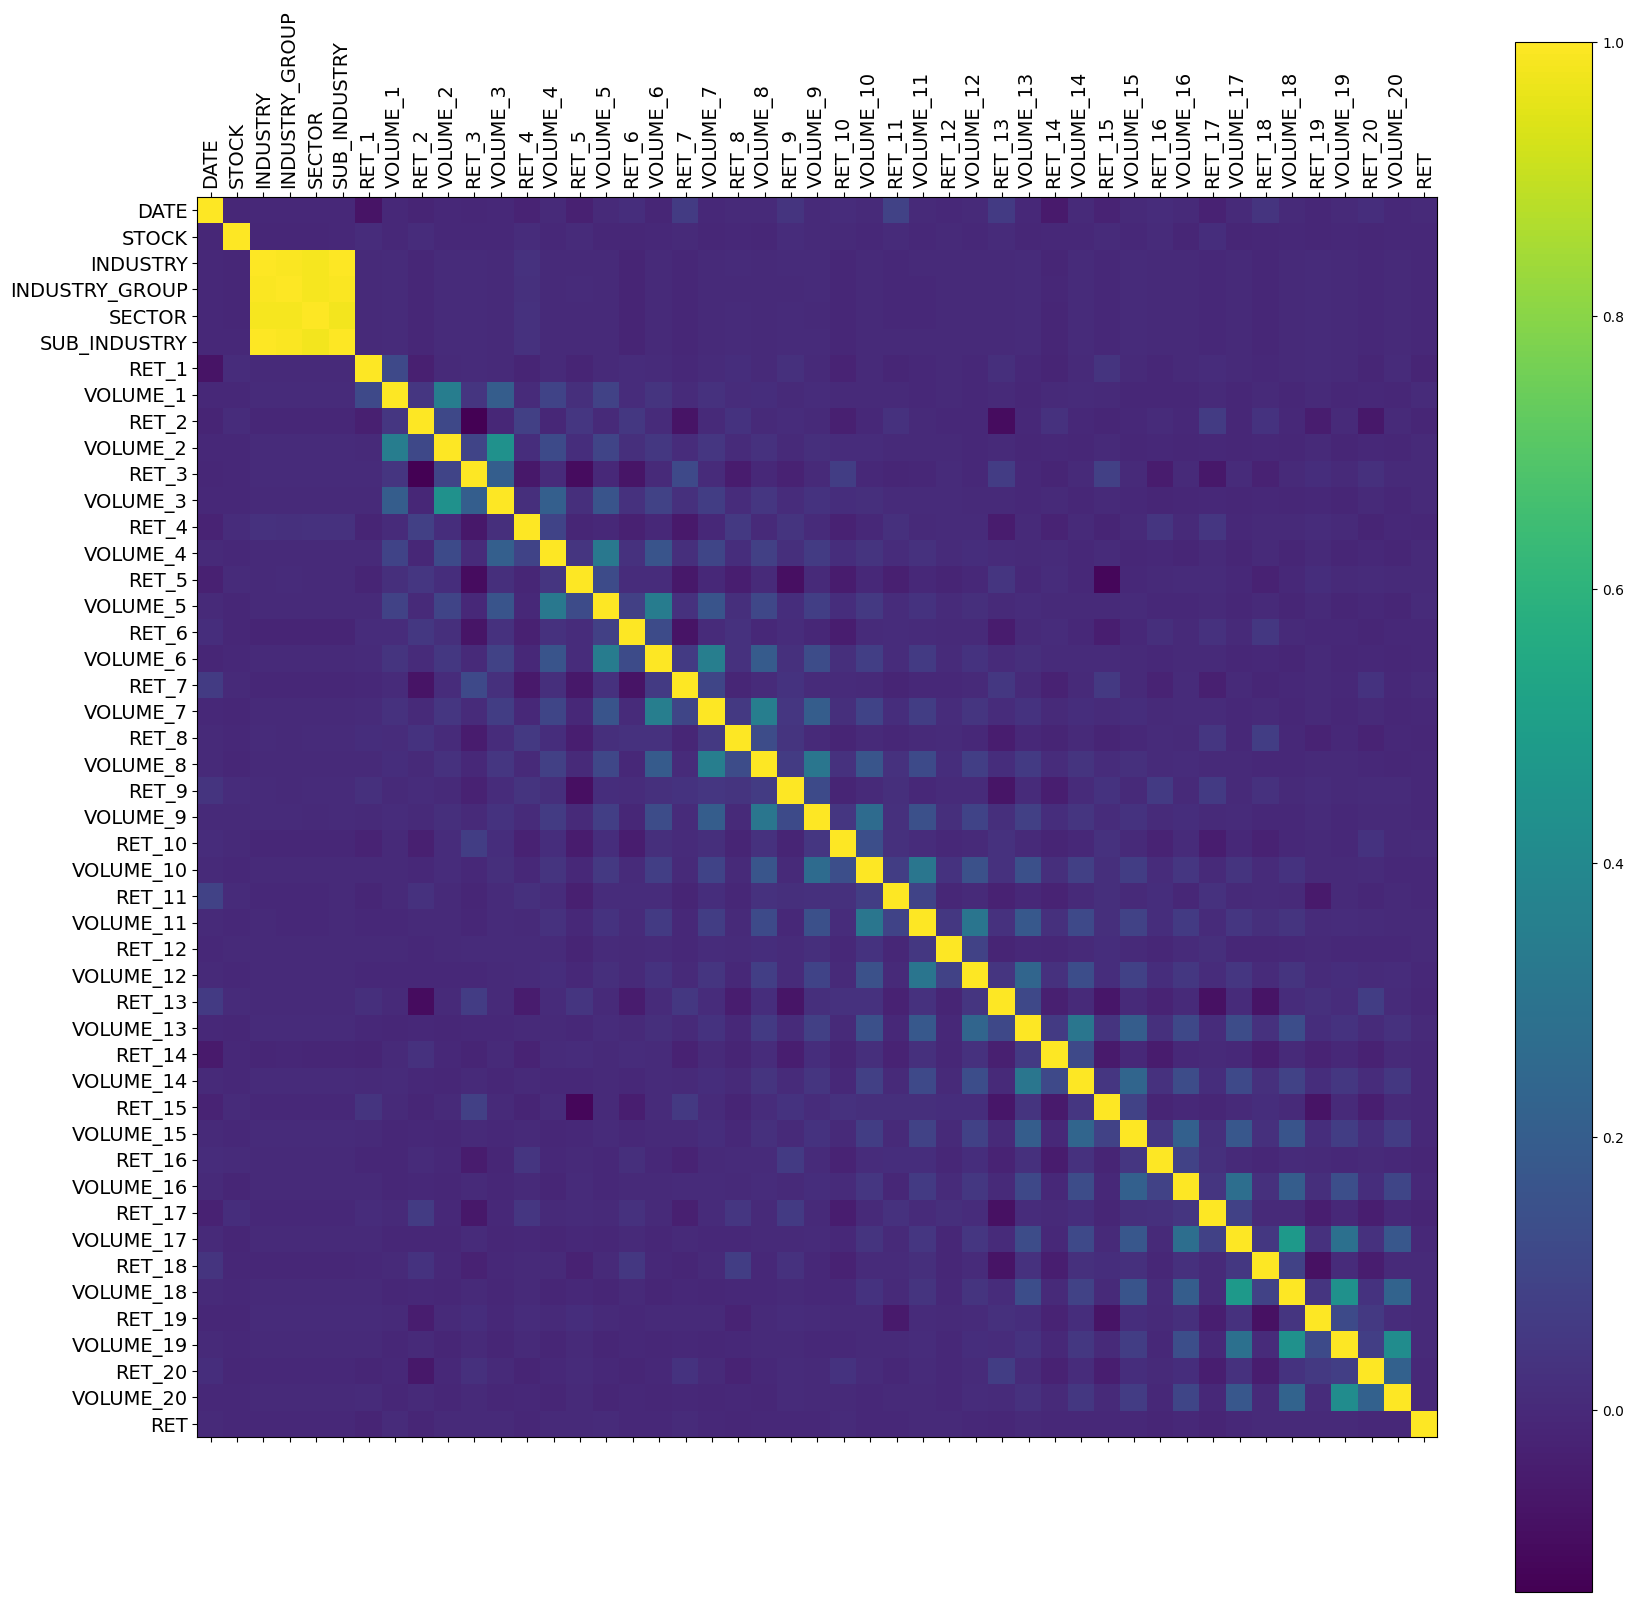

In [83]:
fig = plt.figure(figsize=(20,20))
plt.matshow(train.corr(), fignum=fig.number)
plt.xticks(range(train.shape[1]), train.columns, rotation=90, fontsize=14)
plt.yticks(range(train.shape[1]), train.columns, fontsize=14)
plt.colorbar()
plt.show()

## II.4) Imbalanced Data handling

In [38]:
print(cleaning_train['RET'].value_counts(normalize=True)*100)
print(cleaning_train_iso['RET'].value_counts(normalize=True)*100)
print(cleaning_train_iqr['RET'].value_counts(normalize=True)*100)

RET
False    50.131872
True     49.868128
Name: proportion, dtype: float64
RET
False    50.095145
True     49.904855
Name: proportion, dtype: float64
RET
True     50.679781
False    49.320219
Name: proportion, dtype: float64


## III) Baseline Model

In [ ]:
target = 'RET'

n_shifts = 5  # If you don't want all the shifts to reduce noise
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,VOLUME_1_SECTOR_DATE_INDUSTRY_GROUP_mean,VOLUME_1_SECTOR_DATE_INDUSTRY_GROUP_sum,RET_2_SECTOR_DATE_INDUSTRY_GROUP_mean,RET_2_SECTOR_DATE_INDUSTRY_GROUP_sum,VOLUME_2_SECTOR_DATE_INDUSTRY_GROUP_mean,VOLUME_2_SECTOR_DATE_INDUSTRY_GROUP_sum,RET_3_SECTOR_DATE_INDUSTRY_GROUP_mean,RET_3_SECTOR_DATE_INDUSTRY_GROUP_sum,VOLUME_3_SECTOR_DATE_INDUSTRY_GROUP_mean,VOLUME_3_SECTOR_DATE_INDUSTRY_GROUP_sum
ID,,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,...,-0.087624,-2.190612,-0.017720,-0.443001,-0.301788,-7.544688,0.006560,0.163991,-0.060685,-1.517134
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,...,-0.162249,-11.681946,-0.000775,-0.055824,-0.236083,-16.997984,-0.011175,-0.804632,-0.354640,-25.534099
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,...,-0.153266,-7.356781,-0.006025,-0.289219,-0.246442,-11.829238,-0.004366,-0.209583,-0.206636,-9.918517
5,0.010938,0.021548,-0.016097,-0.027120,-0.007958,-0.238878,-0.322706,0.747003,0.688104,-0.182443,...,-0.153266,-7.356781,-0.006025,-0.289219,-0.246442,-11.829238,-0.004366,-0.209583,-0.206636,-9.918517
6,0.010602,-0.015338,-0.014900,-0.004804,0.002512,-0.139011,-0.242468,-0.262839,-0.327501,-0.185445,...,-0.049201,-3.345659,-0.010306,-0.700782,-0.101803,-6.922626,-0.003316,-0.225479,-0.252589,-17.176038


# III) Baseline Model
**Implementation note (to avoid leakage):**  
We will compute and apply **per-feature medians within each training fold** (e.g., `SimpleImputer(strategy="median")` inside a `sklearn` `Pipeline`) so that statistics from the test/validation data are never used during training.

In [ ]:
X_train = train[features]
y_train = train[target]

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}
xgb_params ={
    "n_estimators":200,       # nombre d'arbres
    "learning_rate":0.1,      # taux d'apprentissage
    "max_depth":5,            # profondeur des arbres
    "subsample":0.8,          # sous-échantillonnage
    "colsample_bytree":0.8,   # proportion de features utilisées par arbre
    "random_state":42,
    "eval_metric":"logloss"   # évite le warning scikit-learn
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
models = [xgb.XGBClassifier(**xgb_params), RandomForestClassifier(**rf_params)]

for model in models :
    scores = []
    splits = KFold(n_splits=n_splits, random_state=0,
                shuffle=True).split(train_dates)

    for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
        local_train_dates = train_dates[local_train_dates_ids]
        local_test_dates = train_dates[local_test_dates_ids]

        local_train_ids = train['DATE'].isin(local_train_dates)
        local_test_ids = train['DATE'].isin(local_test_dates)

        X_local_train = X_train.loc[local_train_ids]
        y_local_train = y_train.loc[local_train_ids]
        X_local_test = X_train.loc[local_test_ids]
        y_local_test = y_train.loc[local_test_ids]

        X_local_train = X_local_train.fillna(0)
        X_local_test = X_local_test.fillna(0)

        model.fit(X_local_train, y_local_train)

        y_local_pred = model.predict_proba(X_local_test)[:, 1] #proba de prédire 1 True
        
        sub = train.loc[local_test_ids].copy() # on garde les lignes du train qu'on va agrémenter de leur proba de predire 1
        sub['pred'] = y_local_pred # on agrémente celle colonne de préditiction
        y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values 

        score = accuracy_score(y_local_test, y_local_pred)
        scores.append(score)
        print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

    mean = np.mean(scores)*100
    std = np.std(scores)*100
    u = (mean + std)
    l = (mean - std)
    print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})\n')

Fold 1 - Accuracy: 50.46%
Fold 2 - Accuracy: 51.62%
Fold 3 - Accuracy: 51.74%
Fold 4 - Accuracy: 52.10%
Accuracy: 51.48% [50.86 ; 52.09] (+- 0.61)

Fold 1 - Accuracy: 50.78%
Fold 2 - Accuracy: 51.54%
Fold 3 - Accuracy: 52.46%
Fold 4 - Accuracy: 51.82%
Accuracy: 51.65% [51.05 ; 52.25] (+- 0.60)



<Axes: >

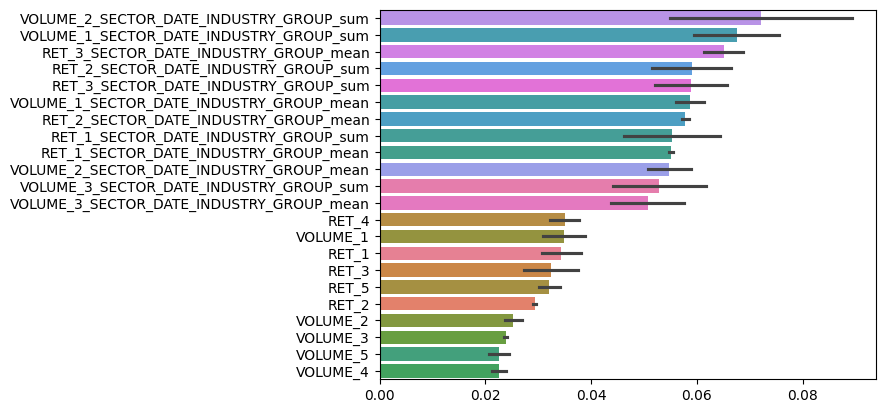

In [ ]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

# Output for challenge submission

In [ ]:
X_test = test[features]

rf_params['random_state'] = 0
model = RandomForestClassifier(**rf_params)
model.fit(X_train.fillna(0), y_train)
y_pred = model.predict_proba(X_test.fillna(0))[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target_feature

submission.to_csv('test.csv', index=True, header=True)